In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imageio.v3 import imread
from scipy.ndimage import rotate
from IPython.display import clear_output
from time import sleep
from random import sample, choice

In [2]:
img = imread('data/training/image_02/0000/000000.png')

df = pd.read_table('data/training/label_02/0000.txt', delimiter=' ', header=None)
df = df[df[2] != "DontCare"]
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
2,0,0,Van,0,0,-1.793451,296.744956,161.752147,455.226042,292.372804,2.000000,1.823255,4.433886,-4.552284,1.858523,13.410495,-2.115488
3,0,1,Cyclist,0,0,-1.936993,737.619499,161.531951,931.112229,374.000000,1.739063,0.824591,1.785241,1.640400,1.675660,5.776261,-1.675458
4,0,2,Pedestrian,0,0,-2.523309,1106.137292,166.576807,1204.470628,323.876144,1.714062,0.767881,0.972283,6.301919,1.652419,8.455685,-1.900245
7,1,0,Van,0,0,-1.796862,294.898777,156.024256,452.199718,284.621269,2.000000,1.823255,4.433886,-4.650955,1.766774,13.581085,-2.121565
8,1,1,Cyclist,0,0,-1.935205,745.017137,156.393157,938.839722,374.000000,1.739063,0.824591,1.785241,1.700640,1.640419,5.778596,-1.664456


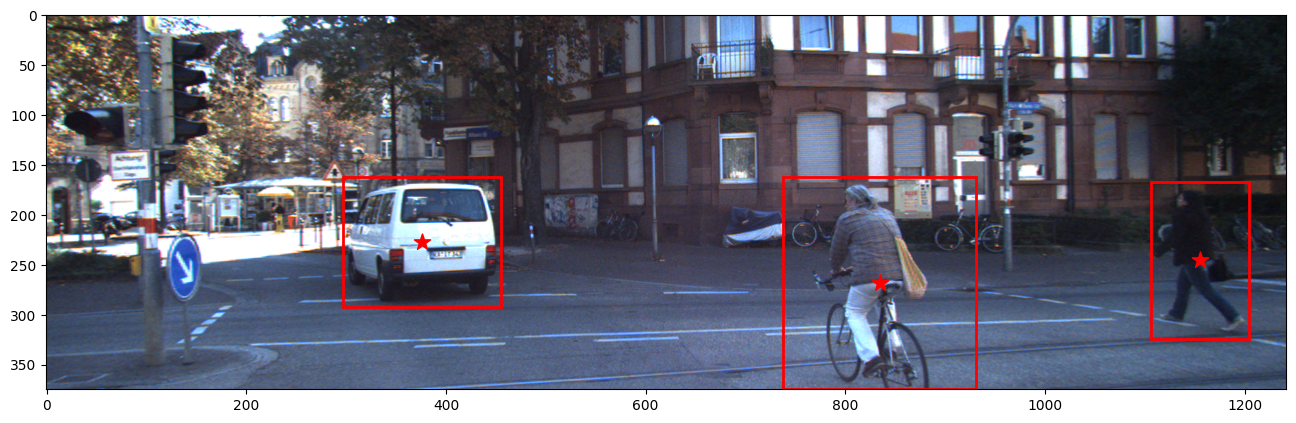

In [3]:
for f in range(df[0].max()):
    _, ax = plt.subplots(figsize=(16, 12))
    img = imread(f'data/training/image_02/0000/{f:06}.png')
    plt.imshow(img)
    for _, (x1, y2, x2, y1) in df[df[0] == f].iloc[:, 6:10].iterrows():
        ax.add_patch(plt.Rectangle([x1, y1], x2 - x1, y2 - y1,
                     edgecolor='r', facecolor='none', linewidth=2))
        ax.scatter((x2 + x1) / 2, (y2 + y1) / 2, marker='*', c='r', s=150)
    sleep(0.5)
    clear_output()
    plt.show()
    break

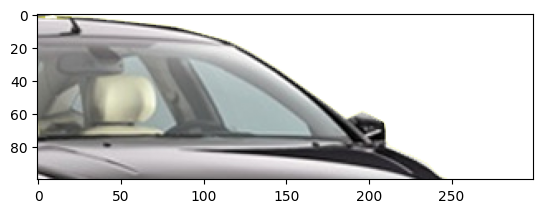

In [69]:
car = np.zeros_like(CAR)
car[:100, -300:] = np.ones((100, 300, 4))
car = car.astype(bool)

plt.imshow(CAR[car].reshape(100, 300, 4))

In [167]:
CAR = imread('car.png') / 255

class Occlusion:
    def __init__(self, data_path, name, occluded_objects=1, occlusion_frames=48, occlusion_type='black'):
        df = pd.read_table(f'{data_path}/label_02/{name}.txt', delimiter=' ', header=None)
        self.df = df[df[2] != "DontCare"]
        self.find_trajectories()
        self.load_images(f"{data_path}/image_02/{name}/{'{:06}.png'}")
        self.dims = np.asarray(self.imgs.shape[1:3])
        self.oo = occluded_objects
        self.ofs = occlusion_frames
        self.type = occlusion_type
    
    def find_trajectories(self):
        self.trajectories = {i: dict() for i in self.df[1].unique()}
        for f in range(self.df[0].max()):
            for _, (f, i, x1, y2, x2, y1) in self.df[self.df[0] == f].iloc[:, np.r_[0:2, 6:10]].iterrows():
                self.trajectories[i][f] = [x1, y1, x2, y2]
    
    def load_images(self, path):
        self.imgs = np.asarray([imread(path.format(f)) for f in range(self.df[0].max())]) / 255
    
    def select_objects(self):
        try: obs = sample(list(self.df[1].unique()), self.oo)
        except ValueError: obs = sample(list(self.df[1].unique()), 1)
        return obs
    
    @staticmethod
    def center_point(bbox):
        x1, y1, x2, y2 = bbox
        return np.asarray([(x2 + x1) / 2, (y2 + y1) / 2])
    
    def select_occlusion_trajectory(self, traj):
        if len(traj) < 3: return
        i = choice(range(1, len(traj) - 1))
        t_frames = sorted(traj.keys())
        velocity = choice([-1, 1]) * self.center_point(traj[t_frames[i+1]]) - self.center_point(traj[t_frames[i]])
        if np.linalg.norm(velocity) == 0: velocity = np.asarray([1, 0])
        self.velocity = velocity / np.linalg.norm(velocity) * self.dims / self.ofs * np.random.uniform(0.9, 1.1)
        self.frame = t_frames[i]

    def calc_margins(self, x, y):
        if self.type == 'car':
            cy, cx = CAR.shape[:2]
            scale = x/cx if cy/cx > y/x else y/cy # Scaling factor to ensure total occlusion
            return np.asarray(CAR.shape[:2][::-1]) / 2 * scale * 1.1
        return np.asarray([x, y]) / 2 * 1.1

    def calc_occlusion_dimensions(self, traj):
        x1, y1, x2, y2 = traj[self.frame]
        return self.calc_margins(x2 - x1, y1 - y2)
    
    def calc_occlusion(self, traj, frame, marg):
        center = self.center_point(traj[self.frame]) + self.velocity * (self.frame - frame)
        occl_bbox = np.asarray([center - marg, center + marg]).flatten()
        if self.type != 'car': occl_bbox += np.random.uniform(0, 10, (4,))
        # return np.clip(occl_bbox.round(), 0, [*self.dims[::-1]] * 2).astype(int)
        return occl_bbox.round().astype(int)

    def add_occlusion_to_frame(self, frame):
        if self.type == 'black':
            return np.zeros(3)
        if self.type == 'noise':
            y, x, c = frame.shape
            return np.random.uniform(size=(y, x, c))
        if self.type == 'car':
            # Ensure that car fragment matches selected fragment
            y, x, _ = frame.shape
            self.car = cv2.resize(self.car, dsize=(x, y), interpolation=cv2.INTER_CUBIC) \
                  if x * y != 0 else np.zeros((y, x, 4))
            if self.velocity[0] > 0: self.car = np.flip(self.car, axis=1)
            frame[self.car[:,:,3] != 0] = self.car[:,:,:3][self.car[:,:,3] != 0]
            return frame

    def cut_car(self, x1, y1, x2, y2):
        self.car = cv2.resize(CAR, dsize=(x2-x1, y2-y1), interpolation=cv2.INTER_CUBIC)
        coords = np.stack(np.meshgrid(np.linspace(x1, x2 - 1, x2 - x1), np.linspace(y1, y2 - 1, y2 - y1)))
        coords = np.moveaxis(coords, (0, 1, 2), (-1, 0, 1))
        mask = np.logical_and(coords >= [0, 0], coords <= self.dims[::-1]).all(axis=-1)
        mask = np.tile(np.expand_dims(mask, -1), (1, 1, 4))
        self.car = self.car[mask].reshape(mask.sum(axis=0).max(), mask.sum(axis=1).max(), 4)
    
    def add_occlusion(self, traj):
        marg = self.calc_occlusion_dimensions(traj)
        for f in range(self.df[0].max()):
            x1, y1, x2, y2 = self.calc_occlusion(traj, f, marg)
            if self.type == 'car':
                self.cut_car(x1, y1, x2, y2)
            x1, y1, x2, y2 = np.clip([x1, y1, x2, y2], 0, [*self.dims[::-1]] * 2)
            self.imgs[f,y1:y2,x1:x2] = self.add_occlusion_to_frame(self.imgs[f,y1:y2,x1:x2])
    
    def add_occlusions(self):
        for o in self.select_objects():
            traj = self.trajectories[o]
            self.select_occlusion_trajectory(traj)
            self.add_occlusion(traj)
    
    def add_bboxes(self, f):
        img = self.imgs[f]
        red = np.asarray([0, 0, 1])
        t = 2 # Line thickness x2
        for _, (x1, y2, x2, y1) in self.df[self.df[0] == f].iloc[:, 6:10].round().astype(int).iterrows():
            img[y1-t:y1+t, x1:x2] = red
            img[y2-t:y2+t, x1:x2] = red
            img[y2:y1, x1-t:x1+t] = red
            img[y2:y1, x2-t:x2+t] = red
        return img
    
    def save_video(self, bboxes=True):
        out = cv2.VideoWriter('test.mp4', cv2.VideoWriter_fourcc('M','J','P','G'), 24, self.dims[::-1].astype(int))
        for f in range(self.imgs.shape[0]):
            f = self.add_bboxes(f) if bboxes else self.imgs[f]
            out.write((f*255).astype('uint8'))
        out.release()

In [169]:
occ = Occlusion('data/training', '0000', occluded_objects=4, occlusion_frames=90, occlusion_type='car')
occ.add_occlusions()
occ.save_video()